# Modelo de recomendación de recetas

### Librerías necesarias

In [1]:
# Para manipulacion de datos
import ast
import numpy as np
import pandas as pd

# Para preparar datos
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Para la construccion del modelo
from keras.layers import Dense, Embedding, Flatten 
from keras.models import Sequential

# Para la evaluacion del modelo
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from collections import Counter


### Data inicial

In [2]:
recipes = pd.read_csv("data/RAW_recipes.csv")
recipes['ingredients'] = recipes['ingredients'].apply(ast.literal_eval)
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


### Preparación de datos

In [3]:

ingredients = ['apple', 'banana', 'orange', 'tomato', 'carrot', 'bread', 'cheese', 'mango', 'broccoli', 'grape', 'lemmon', 'pineapple']

# Filtrando las recetas que contengan al menos 1 ingredieente de la lista o mas
recipes = recipes[recipes['ingredients'].apply(lambda x: any([k in x for k in ingredients]))]
len(recipes)

18122

In [4]:
# Filtrando receptas que contengan 20 ingredientes o menos
max_len = 20
recipes = recipes[recipes['ingredients'].apply(lambda x: all(len(i) <= max_len for i in x))]
len(recipes)

11191

In [5]:
# Representación binaria de los ingredientes
mlb = MultiLabelBinarizer()
ingredients_presence = mlb.fit_transform(recipes['ingredients'])

# Tokenizacion de los ingredientes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipes['ingredients'])
sequences = tokenizer.texts_to_sequences(recipes['ingredients'])
padded_sequences = pad_sequences(sequences)


In [6]:
# Encoding del target (ID de la receta)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(recipes['id'])
one_hot_labels = to_categorical(encoded_labels)

## Modelo con embedding

In [7]:
# Hiperparametros del modelo
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 50
max_length = padded_sequences.shape[1]
recipes_q = recipes['id'].nunique()

# Construccion del modelo
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(recipes_q, activation='softmax'))

# Compilacion del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(padded_sequences, one_hot_labels, epochs=25, verbose=1)

Epoch 1/25
350/350 [==============================] - 2s 5ms/step - loss: 9.3840 - accuracy: 0.0000e+00
Epoch 2/25
350/350 [==============================] - 2s 5ms/step - loss: 9.3317 - accuracy: 0.0000e+00
Epoch 3/25
350/350 [==============================] - 2s 5ms/step - loss: 9.0034 - accuracy: 0.0037
Epoch 4/25
350/350 [==============================] - 2s 5ms/step - loss: 6.2083 - accuracy: 0.1675
Epoch 5/25
350/350 [==============================] - 2s 6ms/step - loss: 1.5014 - accuracy: 0.7161
Epoch 6/25
350/350 [==============================] - 2s 6ms/step - loss: 0.2480 - accuracy: 0.9480
Epoch 7/25
350/350 [==============================] - 2s 6ms/step - loss: 0.1012 - accuracy: 0.9777
Epoch 8/25
350/350 [==============================] - 2s 7ms/step - loss: 0.0666 - accuracy: 0.9848
Epoch 9/25
350/350 [==============================] - 2s 7ms/step - loss: 0.0490 - accuracy: 0.9881
Epoch 10/25
350/350 [==============================] - 2s 7ms/step - loss: 0.0437 - accuracy

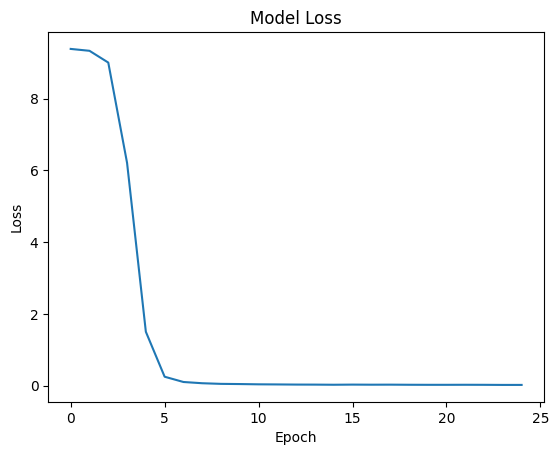

In [8]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


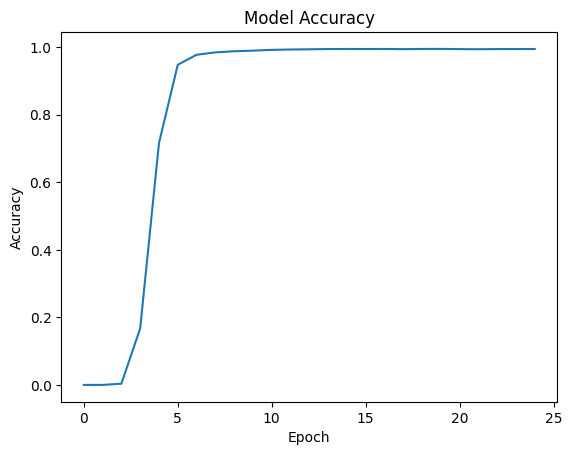

In [9]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [10]:
try_ingredients_2 = ['tomato', 'cheese', 'pasta']

try_ingredients_sequence = tokenizer.texts_to_sequences([try_ingredients_2])
try_ingredients_padded = pad_sequences(try_ingredients_sequence, maxlen=padded_sequences.shape[1])

predictions = model.predict(try_ingredients_padded)
predicted_recipe_id = label_encoder.inverse_transform([np.argmax(predictions)])

print(predicted_recipe_id)

predictions

1/1 [==============================] - 0s 41ms/step
[49602]


array([[1.9630262e-08, 5.9002889e-07, 1.4431507e-07, ..., 2.8138366e-08,
        1.1754772e-07, 4.4463849e-08]], dtype=float32)

In [11]:
try_ingredients = ['bread', 'cheese']
try_ingredients_sequence = tokenizer.texts_to_sequences([try_ingredients])
try_ingredients_padded = pad_sequences(try_ingredients_sequence, maxlen=padded_sequences.shape[1])

predictions = model.predict(try_ingredients_padded)
predicted_recipe_id = label_encoder.inverse_transform([np.argmax(predictions)])

# Top 3 de recetas mas probables
top_3 = predictions.argsort()[0][-5:][::-1]
for i in top_3:
    recipe_id = label_encoder.inverse_transform([i])[0]
    recipe_name = recipes[recipes['id'] == recipe_id]['name'].values[0]
    probability = predictions[0][i]
    print(f'[{recipe_id}] {recipe_name}: {probability*100:.2f}%')

1/1 [==============================] - 0s 21ms/step
[531520] cheeze bread: 84.50%
[9518] 30 second sandwich: 7.61%
[468219] caramelized cheese covered grilled cheese sandwich: 2.39%
[416211] smoked fattie: 1.57%
[81655] justin s cheese bread: 0.75%


## Modelo sin embedding

In [12]:
# Hiperparametros del modelo - sin embedding
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 50
max_length = padded_sequences.shape[1]
recipes_q = recipes['id'].nunique()

# Construccion del modelo
model = Sequential()
model.add(Dense(128, input_dim=ingredients_presence.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(recipes_q, activation='softmax'))

# Compilacion del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(ingredients_presence, one_hot_labels, epochs=25, verbose=1)

Epoch 1/25
350/350 [==============================] - 2s 6ms/step - loss: 9.3839 - accuracy: 0.0000e+00
Epoch 2/25
350/350 [==============================] - 2s 6ms/step - loss: 9.3144 - accuracy: 3.5743e-04
Epoch 3/25
350/350 [==============================] - 2s 6ms/step - loss: 8.1891 - accuracy: 0.0098
Epoch 4/25
350/350 [==============================] - 2s 6ms/step - loss: 4.8712 - accuracy: 0.2252
Epoch 5/25
350/350 [==============================] - 2s 6ms/step - loss: 1.6673 - accuracy: 0.6693
Epoch 6/25
350/350 [==============================] - 2s 6ms/step - loss: 0.3640 - accuracy: 0.9309
Epoch 7/25
350/350 [==============================] - 2s 6ms/step - loss: 0.1349 - accuracy: 0.9729
Epoch 8/25
350/350 [==============================] - 2s 6ms/step - loss: 0.0885 - accuracy: 0.9793
Epoch 9/25
350/350 [==============================] - 2s 6ms/step - loss: 0.0684 - accuracy: 0.9841
Epoch 10/25
350/350 [==============================] - 2s 6ms/step - loss: 0.0577 - accuracy

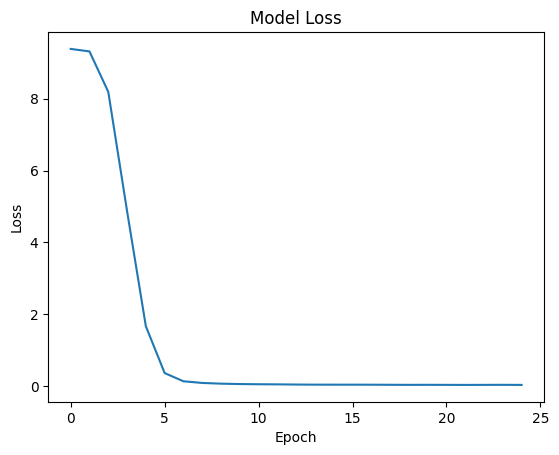

In [13]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


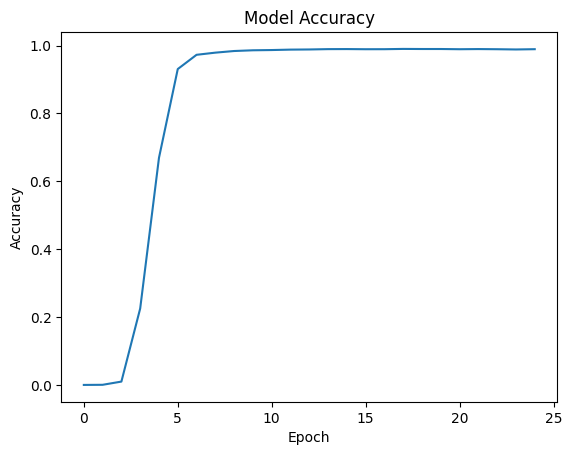

In [14]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [15]:
input_binary = mlb.transform([try_ingredients])

# Predicciones
predictions = model.predict(np.array(input_binary))[0]

# Top 5 de recetas mas probables
top_5 = predictions.argsort()[-5:][::-1]
for i in top_5:
    recipe_id = label_encoder.inverse_transform([i])[0]
    recipe_name = recipes[recipes['id'] == recipe_id]['name'].values[0]
    probability = predictions[i]
    print(f'[{recipe_id}] {recipe_name}: {probability*100:.2f}%')
    

1/1 [==============================] - 0s 29ms/step
[9518] 30 second sandwich: 64.40%
[531520] cheeze bread: 30.00%
[86467] mirowave bacon cheese sandwich: 0.81%
[253282] cheesy corn toasties: 0.66%
[110976] garlic grilled cheese: 0.53%
